<a href="https://colab.research.google.com/github/yjchen9596/tensorflow-for-deep-learning/blob/main/l08c05_forecasting_with_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

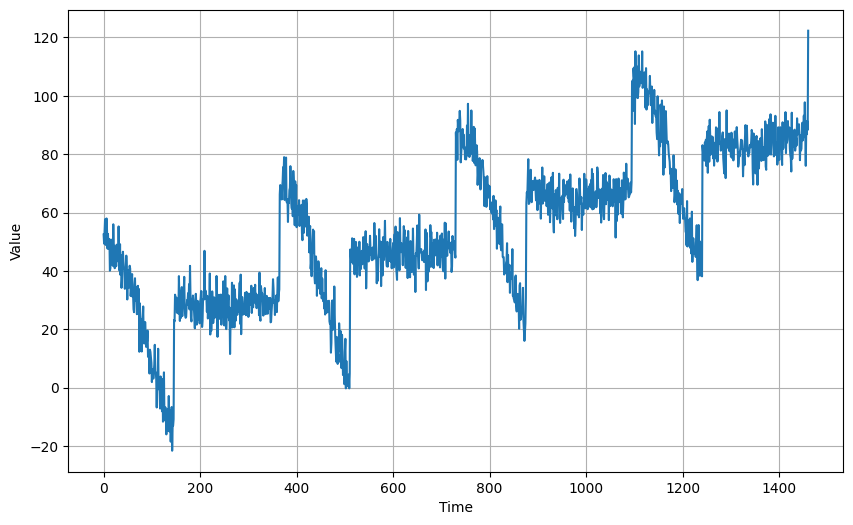

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [5]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


     20/Unknown 2s 3ms/step - loss: 22.0382 - mae: 22.5359

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 19.4651 - mae: 19.9610 - val_loss: 9.4381 - val_mae: 9.9259
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.0318 - mae: 9.5222 - val_loss: 8.1418 - val_mae: 8.6330
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3783 - mae: 8.8617 - val_loss: 8.1134 - val_mae: 8.5996
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.4411 - mae: 8.9250 - val_loss: 7.9101 - val_mae: 8.3921
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.0511 - mae: 8.5394 - val_loss: 9.0315 - val_mae: 9.5183
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8518 - mae: 8.3384 - val_loss: 7.7448 - val_mae: 8.2313
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7269 - mae: 8.2137 - val_loss: 7.9278 - val_mae: 8.4148
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0872 - mae: 8.5716 - val_loss: 7.6319 - val_mae: 8.1159
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7809 - ma

In [10]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 71.6150 - mae: 72.1131 - learning_rate: 1.0000e-06
Epoch 2/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 69.2521 - mae: 69.7521

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 57.8191 - mae: 58.3180 - learning_rate: 1.0798e-06
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.2218 - mae: 41.7195 - learning_rate: 1.1659e-06
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.1258 - mae: 24.6235 - learning_rate: 1.2589e-06
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.3466 - mae: 14.8412 - learning_rate: 1.3594e-06
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2712 - mae: 15.7653 - learning_rate: 1.4678e-06
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.2895 - mae: 14.7820 - learning_rate: 1.5849e-06
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.5702 - mae: 15.0629 - learning_rate: 1.7113e-06
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.3472 - mae: 13.8394 - learning_rate: 1.8478e-06
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.8504 - mae: 14.3436 - learning_rate: 1.9953e-06
Epoch 11/100
31/31 ━━

(np.float64(1e-06), np.float64(0.001), np.float64(0.0), np.float64(20.0))

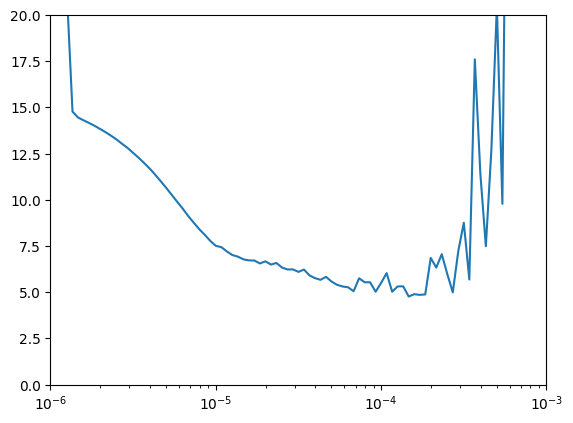

In [11]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 36.7616 - mae: 37.2585 - val_loss: 12.4684 - val_mae: 12.9579
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 10.6520 - mae: 11.1415 - val_loss: 9.6480 - val_mae: 10.1368
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8907 - mae: 9.3758 - val_loss: 9.0617 - val_mae: 9.5516
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8581 - mae: 9.3503 - val_loss: 8.4522 - val_mae: 8.9378
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2346 - mae: 8.7218 - val_loss: 8.0892 - val_mae: 8.5716
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.5285 - mae: 9.0115 - val_loss: 7.9380 - val_mae: 8.4216
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.1184 - mae: 8.6018 - val_loss: 7.8165 - val_mae: 8.3021
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9684 - mae: 8.4521 - val_loss: 8.2104 - val_mae: 8.6964
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - l

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [15]:
lin_forecast.shape

(461,)

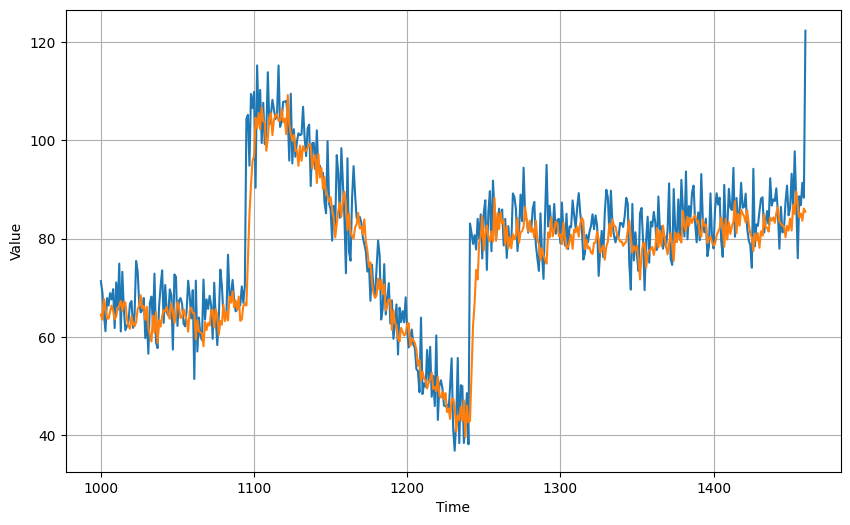

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

Mean Absolute Error (NumPy): 5.1429546116202935
Mean Absolute Error (TensorFlow): 5.1429546116202935


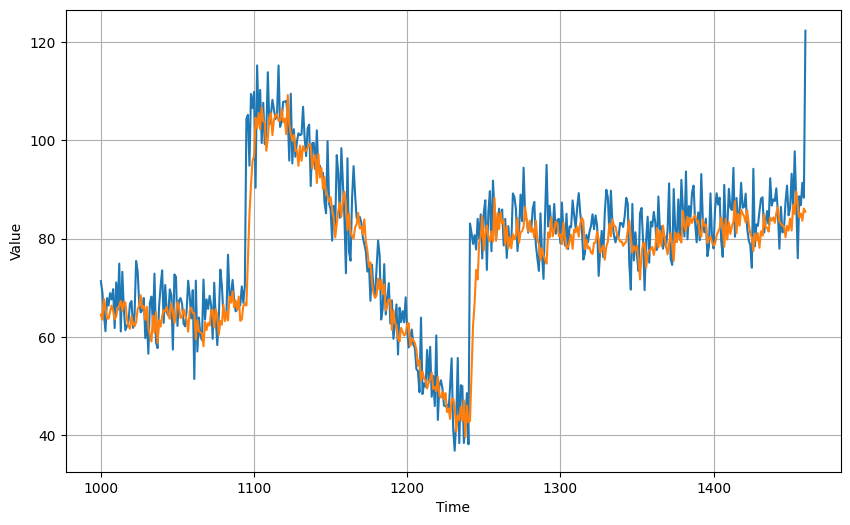

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assume the previous code to define time, series, split_time, x_valid,
# and lin_forecast has been executed.

# Calculate Mean Absolute Error manually using NumPy
mae_numpy = np.mean(np.abs(x_valid - lin_forecast))
print(f"Mean Absolute Error (NumPy): {mae_numpy}")

# Or using TensorFlow operations
mae_tf = tf.reduce_mean(tf.abs(x_valid - lin_forecast)).numpy()
print(f"Mean Absolute Error (TensorFlow): {mae_tf}")


# The rest of the code for plotting can remain the same
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)
plt.show()

### Dense Model Forecasting

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 53.2267 - mae: 53.7263 - learning_rate: 1.0000e-07
Epoch 2/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 52.5941 - mae: 53.0937 - learning_rate: 1.1220e-07
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.0859 - mae: 52.5857 - learning_rate: 1.2589e-07
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.4400 - mae: 50.9390 - learning_rate: 1.4125e-07
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.6078 - mae: 50.1059 - learning_rate: 1.5849e-07
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48.8056 - mae: 49.3045 - learning_rate: 1.7783e-07
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 47.1405 - mae: 47.6375 - learning_rate: 1.9953e-07
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46.2040 - mae: 46.7019 - learning_rate: 2.2387e-07
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.8461 - mae: 43.3446 - learning_rate: 2.5119e-07
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.8848 - mae: 42.3834 - learning_rate: 2.8184e-07
Epoch 11/100
31/31 ━━

(np.float64(1e-07), np.float64(0.005), np.float64(0.0), np.float64(30.0))

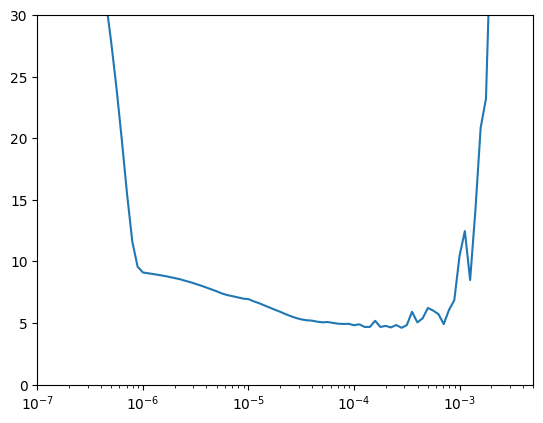

In [21]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 46.6981 - mae: 47.1952 - val_loss: 11.3112 - val_mae: 11.8080
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.5859 - mae: 9.0738 - val_loss: 7.1902 - val_mae: 7.6767
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.5616 - mae: 8.0408 - val_loss: 7.1729 - val_mae: 7.6584
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2630 - mae: 7.7489 - val_loss: 6.4646 - val_mae: 6.9457
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8503 - mae: 7.3310 - val_loss: 6.5553 - val_mae: 7.0356
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.9580 - mae: 7.4401 - val_loss: 6.0919 - val_mae: 6.5677
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8864 - mae: 7.3712 - val_loss: 6.1900 - val_mae: 6.6719
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.6722 - mae: 7.1562 - val_loss: 5.9047 - val_mae: 6.3889
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - lo

In [23]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


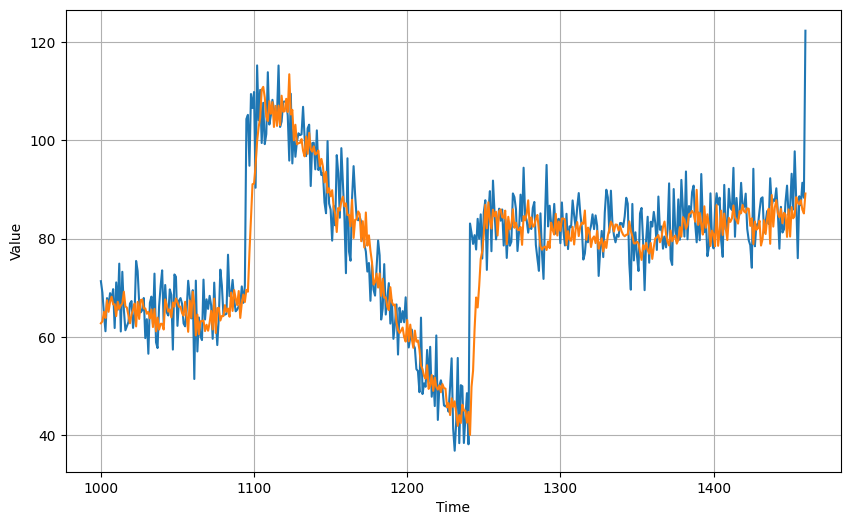

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

Mean Absolute Error (tf.keras.metrics.MeanAbsoluteError): 5.024662494659424
Mean Absolute Error (TensorFlow functional API): 5.024662332485943
Mean Absolute Error (NumPy): 5.024662332485943


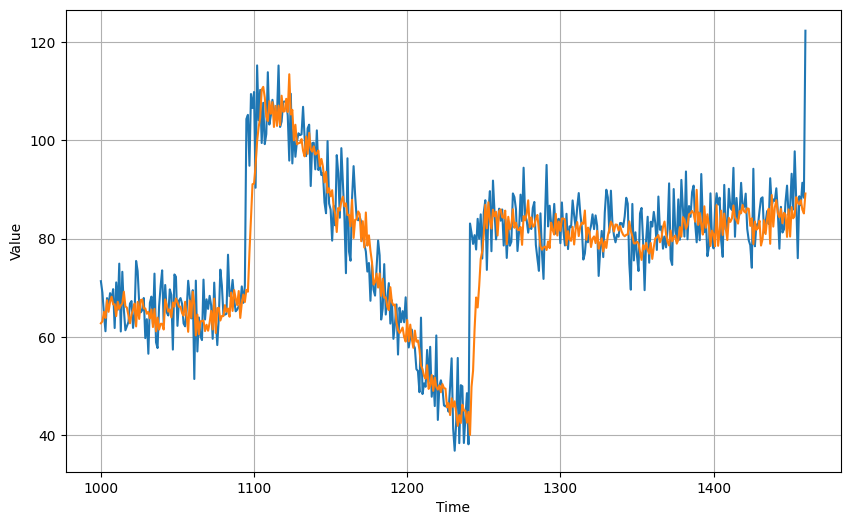

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming the previous code to define x_valid and dense_forecast has been executed.

# Option 1: Using tf.keras.metrics.MeanAbsoluteError class
# Instantiate the metric class and update it with the data.
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mae_metric.update_state(x_valid, dense_forecast)
mae_value_metric = mae_metric.result().numpy()
print(f"Mean Absolute Error (tf.keras.metrics.MeanAbsoluteError): {mae_value_metric}")

# Option 2: Using TensorFlow functional API (as demonstrated previously in the notebook)
mae_value_tf = tf.reduce_mean(tf.abs(x_valid - dense_forecast)).numpy()
print(f"Mean Absolute Error (TensorFlow functional API): {mae_value_tf}")

# Option 3: Using NumPy (as demonstrated previously in the notebook)
mae_value_numpy = np.mean(np.abs(x_valid - dense_forecast))
print(f"Mean Absolute Error (NumPy): {mae_value_numpy}")

# The rest of the code for plotting can remain the same
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)
plt.show()